In [29]:
#imports
import os
from six.moves import urllib
import pandas as pd
import numpy as np 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from statsmodels import robust

In [30]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [31]:
# fetch data from its origin
def fetch_credit_crad_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_crad_data()

In [32]:
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()
dataset.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [33]:
#replace missing numeric values with mean
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)
dataset.fillna(dataset.mean(), inplace=True)
#replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

dataset.isna().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

In [34]:
dataset['ApprovalStatus'].value_counts()

0    383
1    307
Name: ApprovalStatus, dtype: int64

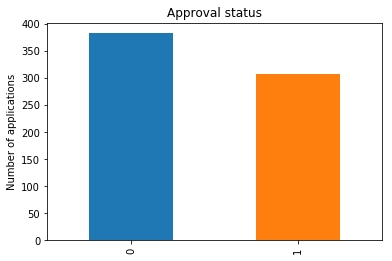

In [35]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [36]:
dataset.dtypes

Gender             object
Age                object
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
ApprovalStatus      int64
dtype: object

In [37]:
#encode values for the algorithm
#ohe = preprocessing.OneHotEncoder()

le = preprocessing.LabelEncoder()

for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset[col]=le.fit_transform(dataset[col])
dataset.dtypes

Gender              int32
Age                 int32
Debt              float64
Married             int32
BankCustomer        int32
EducationLevel      int32
Ethnicity           int32
YearsEmployed     float64
PriorDefault        int32
Employed            int32
CreditScore         int64
DriversLicense      int32
Citizen             int32
ZipCode             int32
Income              int64
ApprovalStatus      int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B92825A240>,
      dtype=object)

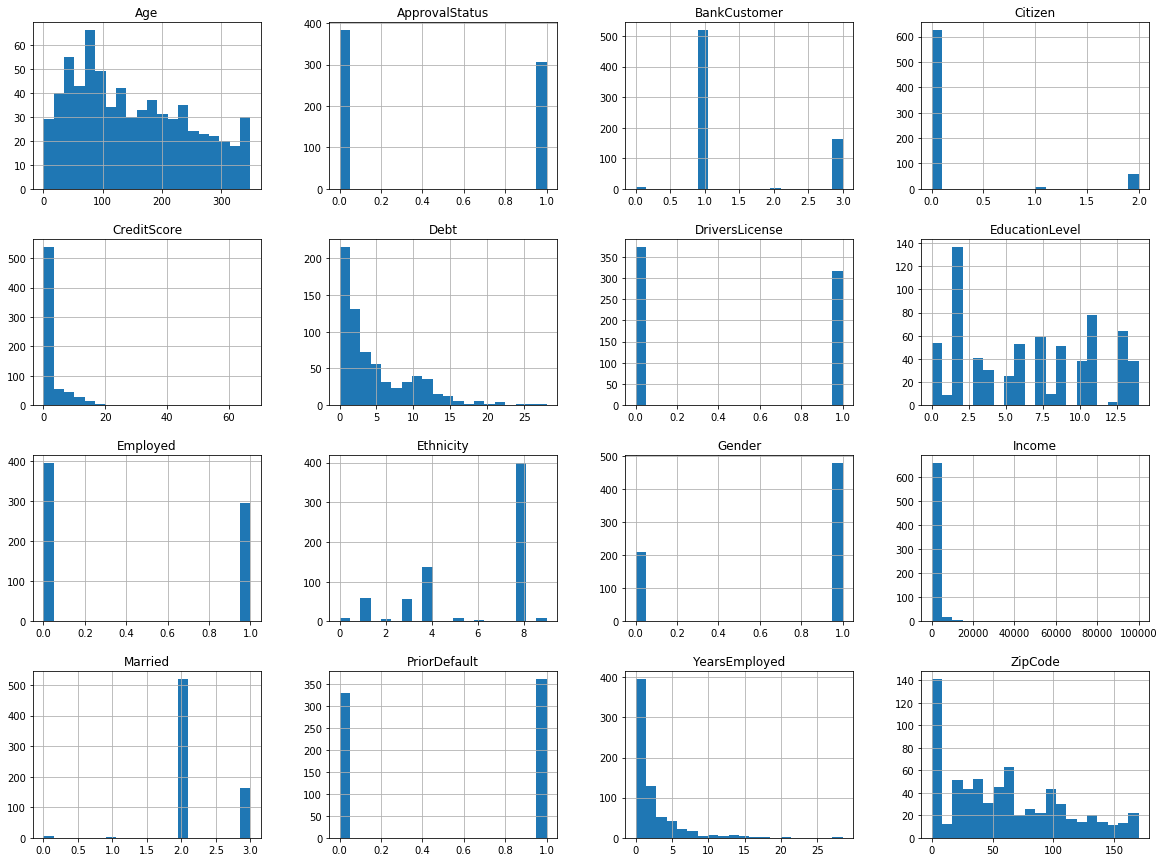

In [38]:
dataset.hist(bins=20, figsize=(20, 15))

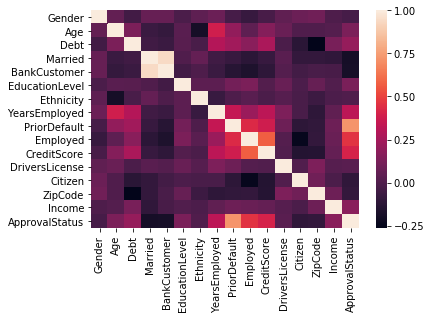

In [40]:
def make_corr_heatmap(data):
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

make_corr_heatmap(dataset)

In [41]:
corr['ApprovalStatus'].sort_values()

Married          -0.191431
BankCustomer     -0.187520
Citizen          -0.100867
ZipCode          -0.094851
Gender           -0.028934
Ethnicity         0.000877
DriversLicense    0.031625
EducationLevel    0.130026
Age               0.133304
Income            0.175657
Debt              0.206294
YearsEmployed     0.322475
CreditScore       0.406410
Employed          0.458301
PriorDefault      0.720407
ApprovalStatus    1.000000
Name: ApprovalStatus, dtype: float64

In [42]:
#use MAD to check the spread of the observation from the mean. MAD > std because we have outliers like age, income
dataset.mad()

Gender               0.423440
Age                 82.546335
Debt                 3.941786
Married              0.370439
BankCustomer         0.727536
EducationLevel       3.875156
Ethnicity            2.395346
YearsEmployed        2.223883
PriorDefault         0.498925
Employed             0.489498
CreditScore          3.088116
DriversLicense       0.496467
Citizen              0.320311
ZipCode             40.415312
Income            1533.165402
ApprovalStatus       0.493934
dtype: float64

In [ ]:
#drop columns with the lowest correlation, or columns that do not make sense
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)

In [45]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:11] , dataset[:,11]

#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [46]:
#rescale the training and testing sets
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [ ]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42)
gnb = GaussianNB()
logreg = LogisticRegression()

In [ ]:
#use cross validation with 5 folds on the training data, since we have low amount of data
#produce the AUC score for each of the algorithms
print("Random Forrest")
roc_rfc = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, X_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, X_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, X_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall: " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("*********")
print("Naive Bayes")
roc_gnb = cross_val_score(gnb, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, X_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, X_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, X_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb = cross_val_score(gnb, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC of Naive Bayes is: " , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall: " , rec_gnb)
print("Accuracy: " , acc_gnb)
print("*********")
print("Logistic regression")
roc_logreg = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, X_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, X_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, X_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precission: " , precision_logreg)
print("Recall: " , rec_logreg)
print("Accuracy: " , acc_gnb)
print("*********")

In [ ]:
#use gridsearch to find best parameters for RandomForest
parameters = { 'max_features':np.arange(5,11),'n_estimators':[10,50,100,200,500],'min_samples_leaf': [10,50,100,200,500]}

random_grid = GridSearchCV(rfc, parameters, cv = 5)
random_grid_result = random_grid.fit(rescaledX_train, y_train)

print("Best:", random_grid_result.best_params_)

In [ ]:
#instantiate rfc with the best parameters
rfc_best_model = RandomForestClassifier(max_features=5,min_samples_leaf=10,n_estimators=10,random_state=42)
#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on validation set
y_pred_val = rfc_best_model.predict(X_val)

In [ ]:
#print the metrics
print("AUC: " ,  metrics.roc_auc_score(y_test,y_pred))
print("F1: " , metrics.f1_score(y_test,y_pred))
print("Precission: " , metrics.precision_score(y_test,y_pred))
print("Recall: " ,  metrics.recall_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred_val, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
threshold = 2.0

y_pred_test = rfc_best_model.predict(rescaledX_test)
predicted = (y_pred_test >= threshold).astype('bool')

accuracy = accuracy_score(y_test, predicted)
print(accuracy)